# Table: term-length-distributions

In [3]:
#!pip install nose spacy nltk
#!python -m spacy download en_core_web_sm

In [4]:
!nosetests
from util import jensen_shannon_distance, kullback_leibler_divergence, build_probability_arrays, distribution_distinct_terms, anchor_text_distribution_distinct_terms, aggregated_anchor_text_distribution_distinct_terms
import pandas as pd
import json
import seaborn as sns
from tqdm import tqdm

.......................
----------------------------------------------------------------------
Ran 23 tests in 2.735s

OK


# Read Term-Length-Distributions from the original Paper

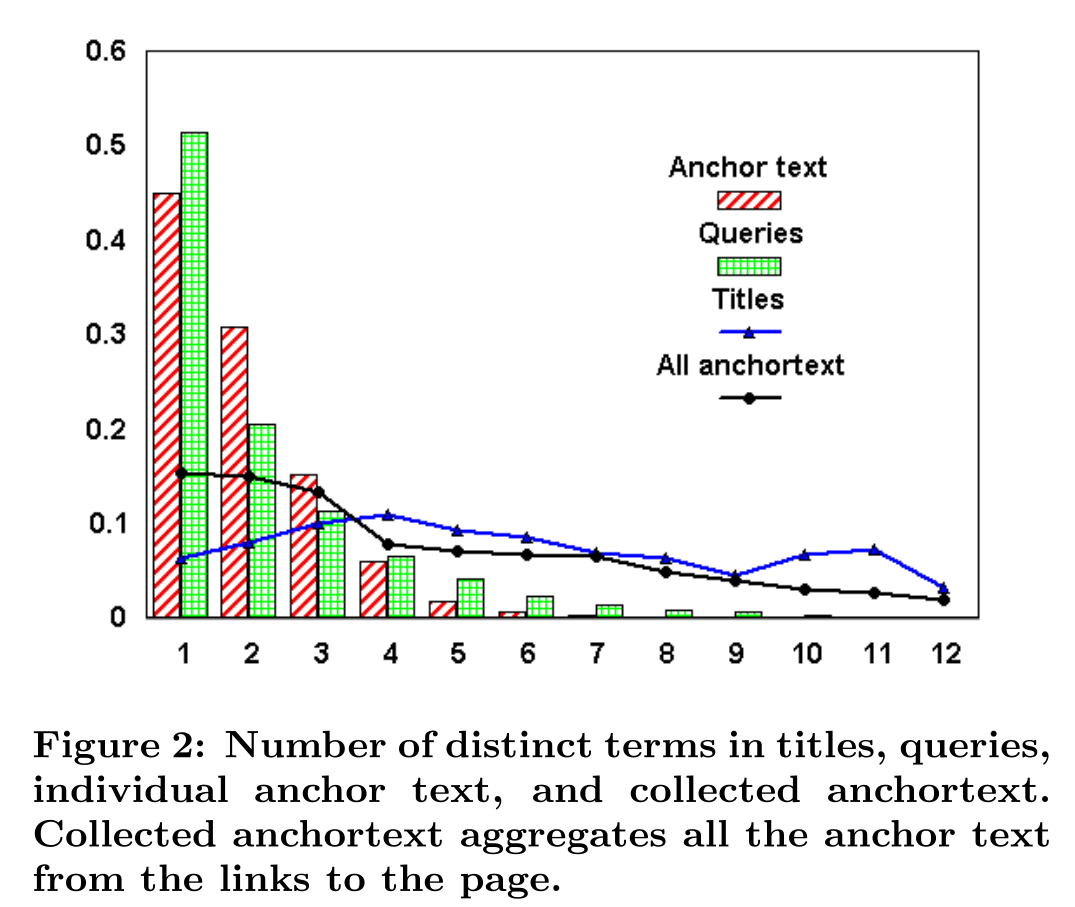

In [5]:
#Reading from the figure above. I expect the following distributions in 1000, i.e. 10 is 1%:

DISTRIBUTIONS_EIRON = {
    'eiron-anchor': {'1': 450, '2': 300, '3': 160, '4': 60, '5': 20, '6': 7, '7': 3},
    'eiron-query': {'1': 515, '2': 205, '3': 120, '4': 65, '5': 40, '6': 20, '7': 15, '8': 10, '9': 7, '10': 3},
    'eiron-anchor-aggregated': {'1': 170, '2': 160, '3': 150, '4': 85, '5': 75, '6': 70, '7': 70, '8': 65, '9': 55, '10': 45, '11': 35, '12': 20},
    'eiron-title': {'1': 75, '2': 85, '3': 95, '4': 110, '5': 90, '6': 85, '7': 75, '8': 75, '9': 60, '10': 110, '11': 115, '12': 25},   
}

# Evaluations on Prepared Data

In [6]:
df = []

distributions = json.load(open('distributions-09-21-2021.json'))

def adjust_zero(a):
    for i in range(len(a)):
        if a[i] <= 0:
            a[i] = 0.00000000000001
    return a

for i in range(len(distributions)):
    for k in range(len(distributions)):
        first_distribution = distributions[i]
        second_distribution = distributions[k]
        p, q = build_probability_arrays(first_distribution[1], second_distribution[1])
        p = adjust_zero(p)
        q = adjust_zero(q)
        
        
        df += [{
            'fist_distribution': first_distribution[0],
            'second_distribution': second_distribution[0],
            'jensen_shannon_distance': jensen_shannon_distance(p, q),
            'kullback_leibler_divergence': kullback_leibler_divergence(p, q),
        }]

df = pd.DataFrame(df)
df.sort_values('kullback_leibler_divergence', ascending=True)

,fist_distribution,second_distribution,jensen_shannon_distance,kullback_leibler_divergence
0,eiron-anchor,eiron-anchor,0.000000,0.000000
54,ms-marco-anchor,ms-marco-anchor,0.000000,0.000000
45,ms-marco-title,ms-marco-title,0.000000,0.000000
36,ms-marco-query,ms-marco-query,0.000000,0.000000
27,eiron-title,eiron-title,0.000000,0.000000
...,...,...,...,...
59,ms-marco-anchor-aggregated,eiron-title,0.357100,6.911203
40,ms-marco-title,eiron-anchor,0.489035,8.270550
57,ms-marco-anchor-aggregated,eiron-query,0.463952,8.592642
24,eiron-title,eiron-anchor,0.547434,11.828691


### Plot Distributions

In [7]:
plot_df = []

for name, distribution in distributions:
    total = sum(distribution.values())
    dataset = 'eiron' if 'eiron' in name else 'ms-marco'
    name = name.split(dataset + '-')[1]
    for num_terms in distribution.keys():
        plot_df += [{
            'dataset': dataset,
            'text': name,
            'distinct_terms': int(num_terms),
            'percentage': distribution[num_terms]/ total
        }]

plot_df = pd.DataFrame(plot_df)
plot_df

,dataset,text,distinct_terms,percentage
0,eiron,anchor,1,4.500000e-01
1,eiron,anchor,2,3.000000e-01
2,eiron,anchor,3,1.600000e-01
3,eiron,anchor,4,6.000000e-02
4,eiron,anchor,5,2.000000e-02
...,...,...,...,...
1282,ms-marco,anchor-aggregated,505,8.596434e-07
1283,ms-marco,anchor-aggregated,542,8.596434e-07
1284,ms-marco,anchor-aggregated,2712,8.596434e-07
1285,ms-marco,anchor-aggregated,1270,8.596434e-07


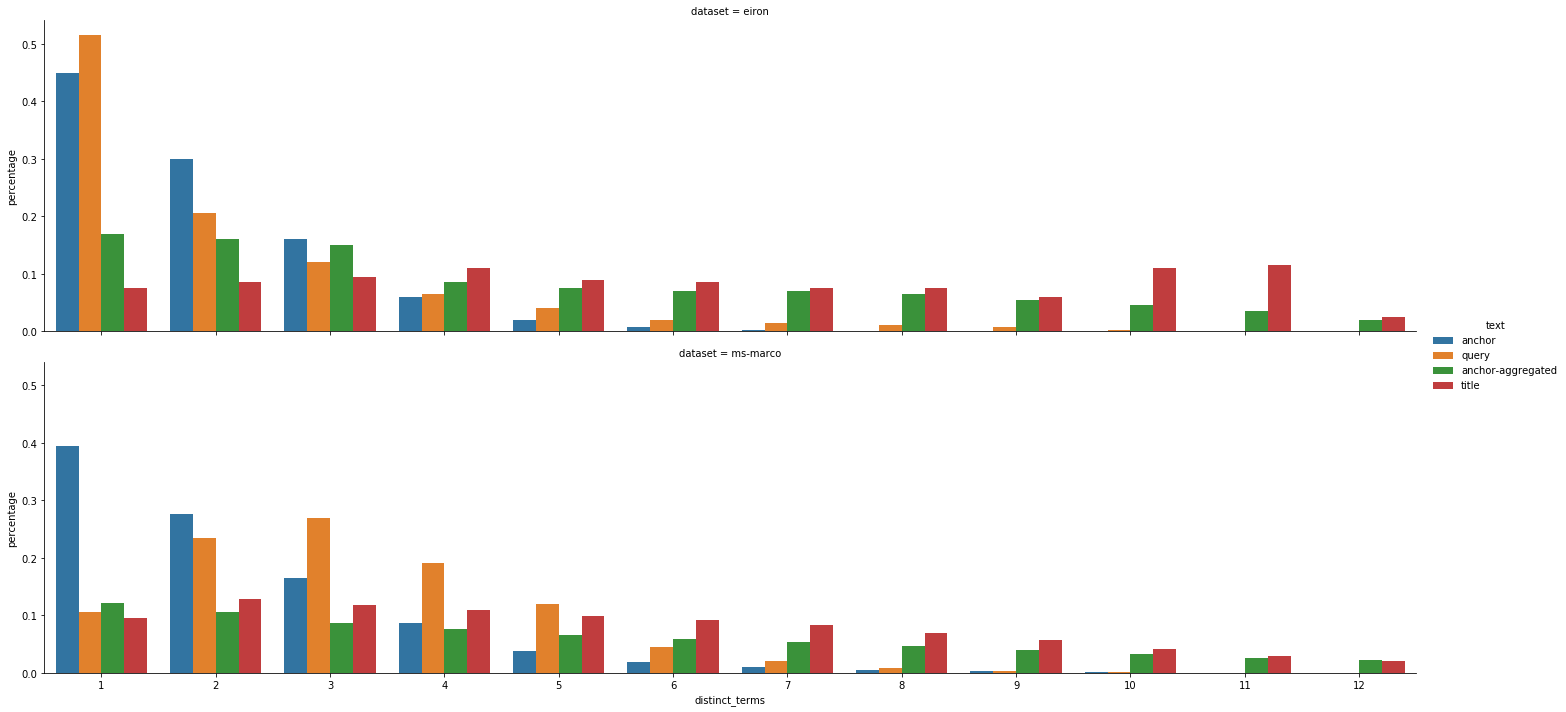

In [18]:
fig = sns.catplot(data=plot_df[(plot_df['distinct_terms'] <= 12) & (plot_df['distinct_terms'] > 0)], x='distinct_terms', y='percentage', hue='text', row='dataset', kind='bar', aspect=4)

fig.savefig('distinct-term-distribution-bar-plot.pdf')

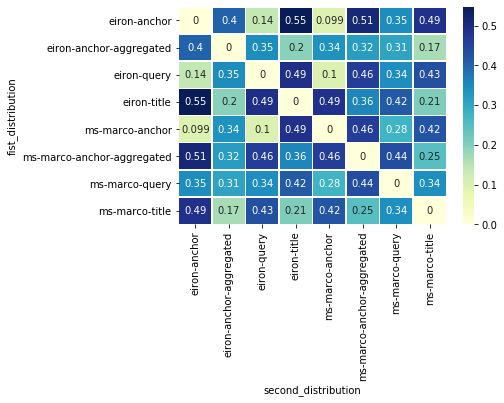

In [13]:
fig = sns.heatmap(df.pivot('fist_distribution', 'second_distribution', 'jensen_shannon_distance'), cmap="YlGnBu", annot=True, linewidths=.5)

fig.figure.savefig('heatmap-distinct-term-distribution.pdf')

# Calculate Distributions file with own distributions

# Attention: The following steps are only required if you need a new distribution.json

In [5]:
DATA_DIR='/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-probst/evaluation-data/'

DISTRIBUTIONS_MS_MARCO = {
    'ms-marco-queries': 'processed-msmarco-v1-orcas.jsonl',
    'ms-marco-title': 'processed-msmarco-v1-title.jsonl',
}

for k in DISTRIBUTIONS_MS_MARCO.keys():
    distribution = distribution_distinct_terms(tqdm(i for i in open(DATA_DIR + DISTRIBUTIONS_MS_MARCO[k])))
    DISTRIBUTIONS_MS_MARCO[k] = distribution


10405342it [00:56, 184764.54it/s]
3213835it [00:20, 159646.87it/s]


In [6]:
DISTRIBUTIONS_MS_MARCO['ms-marco-anchor-limit-100'] = anchor_text_distribution_distinct_terms(tqdm(i for i in open(DATA_DIR + 'processed-msmarco-v1-cc-2019-47-anchors.jsonl')), limit=100)

1163273it [04:39, 4158.79it/s]


In [ ]:
DISTRIBUTIONS_MS_MARCO['ms-marco-anchor-aggregated-limit-100'] = aggregated_anchor_text_distribution_distinct_terms(tqdm(i for i in open(DATA_DIR + 'processed-msmarco-v1-cc-2019-47-anchors.jsonl')), limit=100)

1153982it [06:55, 4320.43it/s]

In [10]:
DISTRIBUTIONS_MS_MARCO['ms-marco-anchor'] = anchor_text_distribution_distinct_terms(tqdm(i for i in open(DATA_DIR + 'processed-msmarco-v1-cc-2019-47-anchors.jsonl')))
DISTRIBUTIONS_MS_MARCO['ms-marco-anchor-aggregated'] = aggregated_anchor_text_distribution_distinct_terms(tqdm(i for i in open(DATA_DIR + 'processed-msmarco-v1-cc-2019-47-anchors.jsonl')))

In [ ]:
distributions = [(k,v) for k,v in DISTRIBUTIONS_EIRON.items()]
distributions += [(k,v) for k,v in DISTRIBUTIONS_MS_MARCO.items()]

print('Persist it')

import json

json.dump(distributions, open('distributions-09-21-2021.json', 'w'))